In [1]:
import torch

path = "cora/"
cites = path + "cora_cites.txt"
content = path + "cora_content.txt"

# 索引字典，将原本的论文id转换到从0开始编码
index_dict = dict()
# 标签字典，将字符串标签转化为数值
label_to_index = dict()

features = []
labels = []
edge_index = []

with open(content,"r") as f:
    nodes = f.readlines()
    for node in nodes:
        node_info = node.split()
        index_dict[int(node_info[0])] = len(index_dict)
        features.append([int(i) for i in node_info[1:-1]])
        
        label_str = node_info[-1]
        if(label_str not in label_to_index.keys()):
            label_to_index[label_str] = len(label_to_index)
        labels.append(label_to_index[label_str])

with open(cites,"r") as f:
    edges = f.readlines()
    for edge in edges:
        start, end = edge.split()
        # 训练时将边视为无向的，但原本的边是有向的，因此需要正反添加两次
        edge_index.append([index_dict[int(start)],index_dict[int(end)]])
        edge_index.append([index_dict[int(end)],index_dict[int(start)]])

# 为每个节点增加自环，但后续GCN层默认会添加自环，跳过即可
# for i in range(2708):
#     edge_index.append([i,i])
  
# 转换为Tensor
labels = torch.LongTensor(labels)
features = torch.FloatTensor(features)
# 行归一化
# features = torch.nn.functional.normalize(features, p=1, dim=1)
edge_index =  torch.LongTensor(edge_index)



In [2]:
class GCNNet(torch.nn.Module):
    def __init__(self, num_feature, num_label):
        super(GCNNet,self).__init__()
        self.GCN1 = GCNConv(num_feature, 128)
        self.GCN2 = GCNConv(128, 64)
        self.GCN3 = GCNConv(64,32)
        self.GCN4 = GCNConv(32,num_label)  
        self.dropout = torch.nn.Dropout(p=0.3)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.GCN1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.GCN2(x, edge_index)
        x = F.relu(x)
        x = self.GCN3(x,edge_index)
        x = F.relu(x)
        x = self.GCN4(x,edge_index)
        x = F.relu(x)
        
        return F.log_softmax(x, dim=1)


In [3]:
class GATNet(torch.nn.Module):
    def __init__(self, num_feature, num_label):
        super(GATNet,self).__init__()
        self.GAT1 = GATConv(num_feature, 8, heads = 8, concat = True, dropout = 0.6)
        self.GAT2 = GATConv(8*8, num_label, dropout = 0.6)  
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.GAT1(x, edge_index)
        x = F.relu(x)
        x = self.GAT2(x, edge_index)
        
        return F.log_softmax(x, dim=1)


In [4]:
import numpy as np
# seed = 1234
seed = 5678
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  # Numpy module.
# random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


In [5]:
from torch_geometric.data import Data

In [6]:
mask = torch.randperm(len(index_dict))
train_mask = mask[:140]
val_mask = mask[140:640]
test_mask = mask[1708:2708]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cora = Data(x = features, edge_index = edge_index.t().contiguous(), y = labels).to(device)


In [7]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,GATConv,SAGEConv
from torch_geometric.datasets import Planetoid

In [8]:
# model = GATNet(features.shape[1], len(label_to_index)).to(device)
model = GCNNet(features.shape[1], len(label_to_index)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(300):
    optimizer.zero_grad()
    out = model(cora)
    loss = F.nll_loss(out[train_mask], cora.y[train_mask])
    print('epoch: %d loss: %.4f' %(epoch, loss))
    loss.backward()
    optimizer.step()
    
    if((epoch + 1)% 10 == 0):
        model.eval()
        _, pred = model(cora).max(dim=1)
        correct = int(pred[test_mask].eq(cora.y[test_mask]).sum().item())
        acc = correct / len(test_mask)
        print('Accuracy: {:.4f}'.format(acc))
        model.train()


epoch: 0 loss: 1.9471
epoch: 1 loss: 1.8696
epoch: 2 loss: 1.6745
epoch: 3 loss: 1.4192
epoch: 4 loss: 1.1515
epoch: 5 loss: 0.9242
epoch: 6 loss: 0.7706
epoch: 7 loss: 0.6554
epoch: 8 loss: 0.5750
epoch: 9 loss: 0.5286
Accuracy: 0.6710
epoch: 10 loss: 0.4873
epoch: 11 loss: 0.4515
epoch: 12 loss: 0.4392
epoch: 13 loss: 0.4197
epoch: 14 loss: 0.4241
epoch: 15 loss: 0.4235
epoch: 16 loss: 0.4152
epoch: 17 loss: 0.4190
epoch: 18 loss: 0.4126
epoch: 19 loss: 0.4083
Accuracy: 0.6490
epoch: 20 loss: 0.4214
epoch: 21 loss: 0.4031
epoch: 22 loss: 0.4174
epoch: 23 loss: 0.3948
epoch: 24 loss: 0.4047
epoch: 25 loss: 0.3955
epoch: 26 loss: 0.3896
epoch: 27 loss: 0.4025
epoch: 28 loss: 0.3972
epoch: 29 loss: 0.4072
Accuracy: 0.6350
epoch: 30 loss: 0.3953
epoch: 31 loss: 0.3938
epoch: 32 loss: 0.3937
epoch: 33 loss: 0.3957
epoch: 34 loss: 0.4112
epoch: 35 loss: 0.3938
epoch: 36 loss: 0.3908
epoch: 37 loss: 0.4166
epoch: 38 loss: 0.3899
epoch: 39 loss: 0.3929
Accuracy: 0.6340
epoch: 40 loss: 0.4006

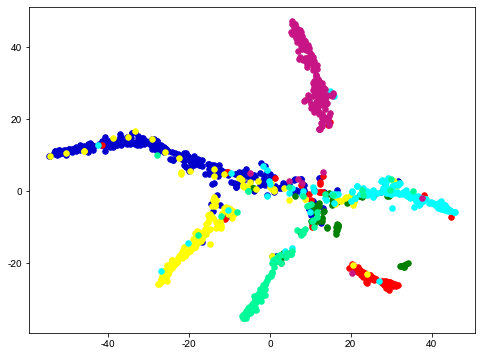

In [11]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

import matplotlib


ts = TSNE(n_components=2)
ts.fit_transform(out[test_mask].to('cpu').detach().numpy())

x = ts.embedding_
y = cora.y[test_mask].to('cpu').detach().numpy()

xi = []
for i in range(7):
    xi.append(x[np.where(y==i)])

colors = ['mediumblue','green','red','yellow','cyan','mediumvioletred','mediumspringgreen']
plt.figure(figsize=(8, 6))
# plt.title('GCN_4_layer') 
for i in range(7):
    plt.scatter(xi[i][:,0],xi[i][:,1],s=30,color=colors[i],marker='o',alpha=1)

plt.savefig('GCN_4_layer_5678.png')


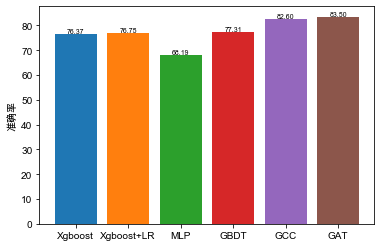

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import random
# mpl.rcParams['font.sans-serif'] = u'SimHei'
# 准备数据
x_data = ['Xgboost','Xgboost+LR','MLP','GBDT','GCC','GAT']
y_data = [76.37,76.75,68.19,77.31,82.60,83.50]

# 正确显示中文和负号
plt.rcParams["font.sans-serif"] = u'SimHei'
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

for a,b in zip(x_data,y_data):   #柱子上的数字显示
 plt.text(a,b,'%.2f'%b,ha='center',va='bottom',fontsize=7);


# 画图，plt.bar()可以画柱状图
for i in range(len(x_data)):
	plt.bar(x_data[i], y_data[i])
# 设置图片名称
# plt.title("模型准确率比较")
# 设置x轴标签名
# plt.xlabel("模型")
# 设置y轴标签名
plt.ylabel("准确率")
# 显示
# plt.show()


plt.savefig('model_5678.jpg', dpi=800,bbox_inches='tight')

